# ESDA Bus Stops

Goh Si hui  
October 12, 2024

# Intent of this notebook

Apply appropriate spatial statistical methods to - discover if bus stops are even distributed geographically. - find out if there are any sign of spatial clusterings, and if yes, where are these clusters.

# Setting up the environment

## Packages

In [ ]:
pacman::p_load(sf, spdep, tmap, tidyverse, knitr)

## Import data

### bus stop locations

In [ ]:
busstops<- st_read(dsn = "data/spatial",
                   layer = "BusStop") %>%
  st_transform(crs = 3414)

Reading layer `BusStop' from data source 
  `C:\sihuihui\mitbcapstone\notebooks\data\spatial' using driver `ESRI Shapefile'
Simple feature collection with 5166 features and 3 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 3970.122 ymin: 26482.1 xmax: 48285.52 ymax: 52983.82
Projected CRS: SVY21

In [ ]:
glimpse(busstops)

Rows: 5,166
Columns: 4
$ BUS_STOP_N <chr> "65059", "16171", "61101", "01239", "17269", "11291", "1153…
$ BUS_ROOF_N <chr> "B12", "B06", "NIL", "B01", "B01", "B17", "B12", "B05", "B0…
$ LOC_DESC   <chr> "ST ANNE'S CH", "YUSOF ISHAK HSE", "BLK 120", "SULTAN PLAZA…
$ geometry   <POINT [m]> POINT (35565.66 41659.52), POINT (21439.91 31253.63),…

## Hexagon layer

In [ ]:
mpsz <-st_read(dsn = "data/spatial",
               layer = "MPSZ-2019") %>% 
  st_transform(crs = 3414)

Reading layer `MPSZ-2019' from data source 
  `C:\sihuihui\mitbcapstone\notebooks\data\spatial' using driver `ESRI Shapefile'
Simple feature collection with 332 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 103.6057 ymin: 1.158699 xmax: 104.0885 ymax: 1.470775
Geodetic CRS:  WGS 84

hexagon grid with 400m from 1 edge to the opposite

In [ ]:
hex_layer <-
  st_make_grid(mpsz,
               cellsize = 400,
               what = "polygon",
               square = FALSE) %>%
  st_sf()

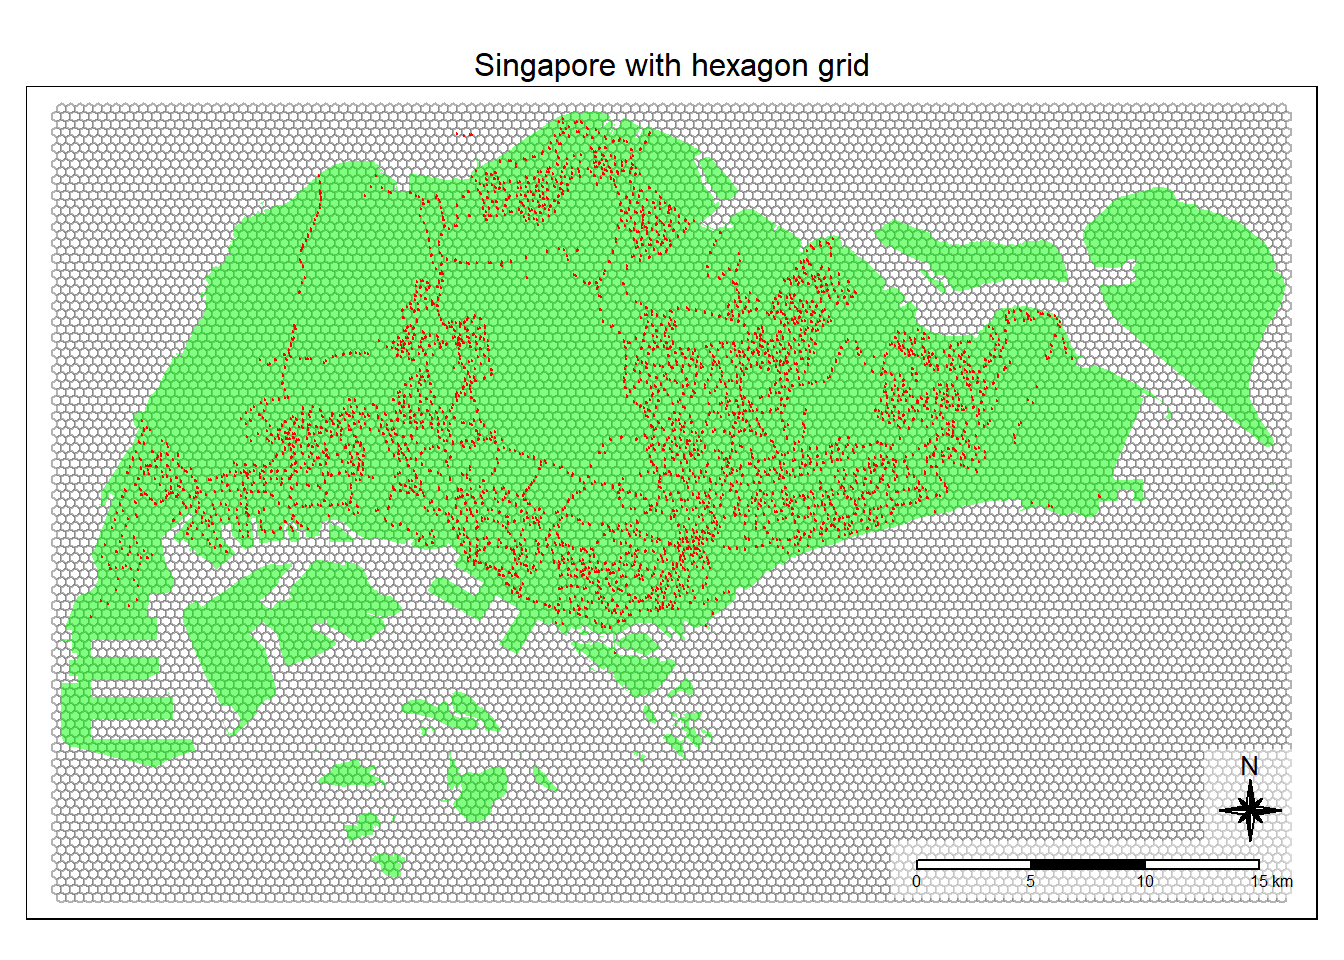

In [ ]:
tm_shape(hex_layer) +
  tm_fill(col = "white", title = "Hexagons") +
  tm_borders(alpha = 0.5) +
  tm_layout(main.title = "Singapore with hexagon grid",
            main.title.position = "center",
            main.title.size = 1.0,
            legend.height = 0.35, 
            legend.width = 0.35,
            frame = TRUE) +
  tm_compass(type="8star", size = 2, bg.color = "white", bg.alpha = 0.5) +
  tm_scale_bar(bg.color = "white", bg.alpha = 0.5) +
  tm_shape(mpsz) +
  tm_fill("green", title = "Singapore Boundary", alpha = 0.5) +
  tm_shape(busstops) +
  tm_dots(col = "red", size = 0.005, title = "Bus Stops")

In [ ]:
hex_layer$n_busstops = lengths(st_intersects(hex_layer, busstops))
hex_layer <- filter(hex_layer, n_busstops > 0)

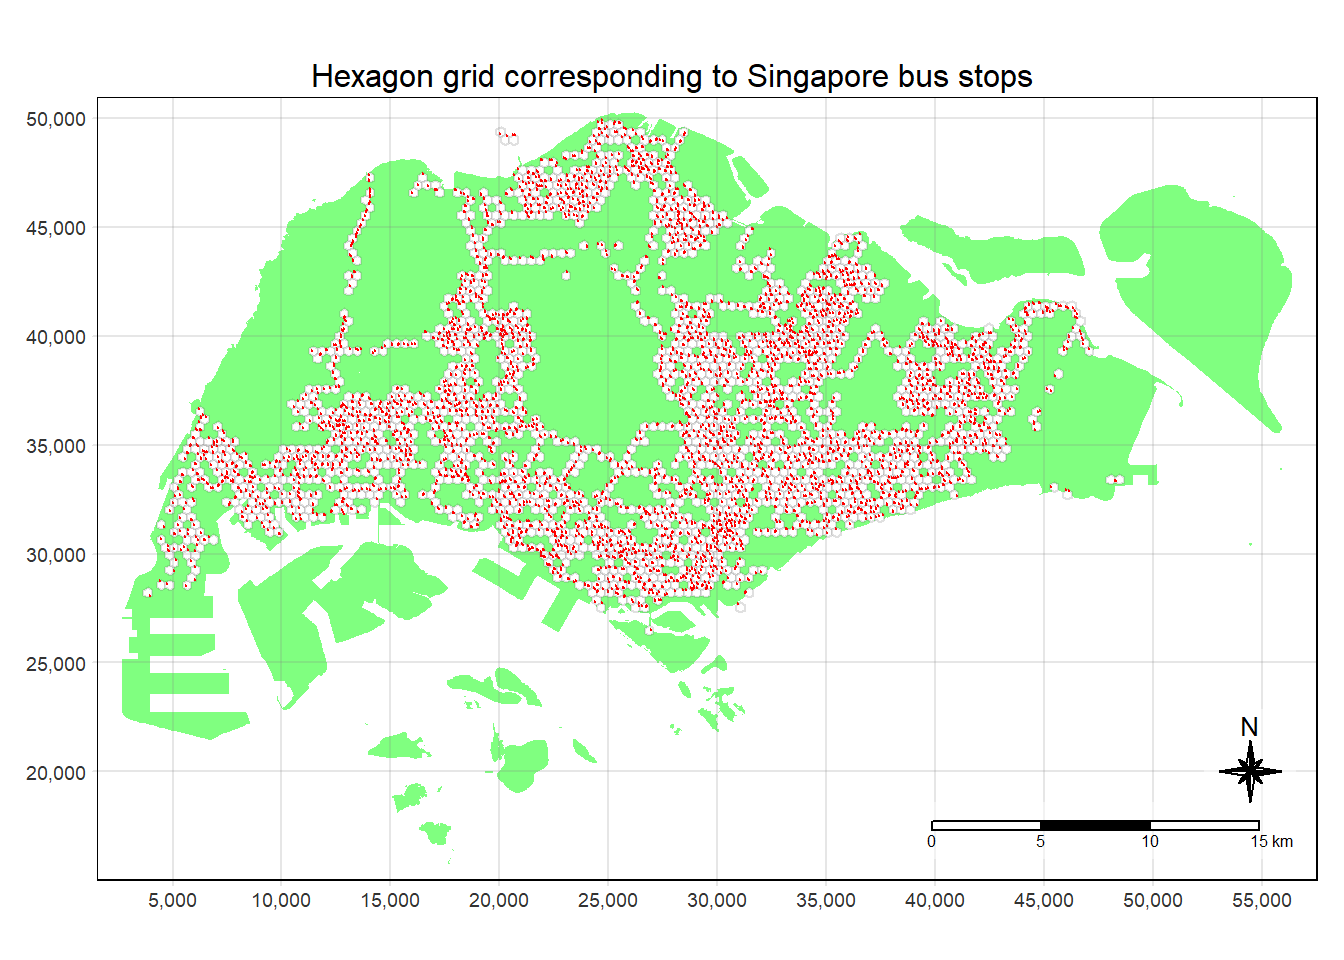

In [ ]:
tm_shape(mpsz) +
  tm_fill("green", title = "Singapore Boundary", alpha = 0.5) +
  tm_shape(hex_layer) +
  tm_fill(col = "white", title = "Hexagons", alpha = 1) +
  tm_borders(alpha = 0.2) +
  tm_layout(main.title = "Hexagon grid corresponding to Singapore bus stops",
            main.title.position = "center",
            main.title.size = 1.0,
            legend.height = 0.35, 
            legend.width = 0.35,
            frame = TRUE) +
  tm_compass(type="8star", size = 2, bg.color = "white", bg.alpha = 0.5) +
  tm_scale_bar(bg.color = "white", bg.alpha = 0.5) +
  tm_shape(busstops) +
  tm_dots(col = "red", size = 0.001, title = "Bus Stops") +
  tm_grid(alpha = 0.2)

assign ids to hexagon cell

In [ ]:
head(hex_layer)

Simple feature collection with 6 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 3667.538 ymin: 27988.55 xmax: 5067.538 ymax: 31568.12
Projected CRS: SVY21 / Singapore TM
                        geometry n_busstops
1 POLYGON ((3867.538 27988.55...          1
2 POLYGON ((4467.538 28334.96...          1
3 POLYGON ((4467.538 30413.42...          1
4 POLYGON ((4467.538 31106.24...          1
5 POLYGON ((4667.538 30067.01...          2
6 POLYGON ((4867.538 28334.96...          1

In [ ]:
hex_layer$hex_id <- sprintf("H%04d", seq_len(nrow(hex_layer))) %>% as.factor()
head(hex_layer)

Simple feature collection with 6 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 3667.538 ymin: 27988.55 xmax: 5067.538 ymax: 31568.12
Projected CRS: SVY21 / Singapore TM
                        geometry n_busstops hex_id
1 POLYGON ((3867.538 27988.55...          1  H0001
2 POLYGON ((4467.538 28334.96...          1  H0002
3 POLYGON ((4467.538 30413.42...          1  H0003
4 POLYGON ((4467.538 31106.24...          1  H0004
5 POLYGON ((4667.538 30067.01...          2  H0005
6 POLYGON ((4867.538 28334.96...          1  H0006

### passenger trips

In [ ]:
apr_od<- read_csv("data/aspatial/origin_destination_bus_202404.csv")

Rows: 5667461 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): YEAR_MONTH, DAY_TYPE, PT_TYPE, ORIGIN_PT_CODE, DESTINATION_PT_CODE
dbl (2): TIME_PER_HOUR, TOTAL_TRIPS

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
glimpse(apr_od)

Rows: 5,667,461
Columns: 7
$ YEAR_MONTH          <chr> "2024-04", "2024-04", "2024-04", "2024-04", "2024-…
$ DAY_TYPE            <chr> "WEEKENDS/HOLIDAY", "WEEKDAY", "WEEKENDS/HOLIDAY",…
$ TIME_PER_HOUR       <dbl> 16, 16, 14, 14, 17, 17, 17, 17, 7, 17, 14, 10, 20,…
$ PT_TYPE             <chr> "BUS", "BUS", "BUS", "BUS", "BUS", "BUS", "BUS", "…
$ ORIGIN_PT_CODE      <chr> "04168", "04168", "80119", "80119", "44069", "4406…
$ DESTINATION_PT_CODE <chr> "10051", "10051", "90079", "90079", "17229", "1722…
$ TOTAL_TRIPS         <dbl> 2, 9, 6, 8, 1, 2, 17, 2, 6, 2, 5, 3, 7, 1, 5, 2, 1…

# Data Wrangling of Aspatial Data

Need to process the od trips data

## data type

convert from character to factor data type.

In [ ]:
apr_od$ORIGIN_PT_CODE <- as.factor(apr_od$ORIGIN_PT_CODE)
apr_od$DESTINATION_PT_CODE <- as.factor(apr_od$DESTINATION_PT_CODE)

Check the data again

In [ ]:
glimpse(apr_od)

Rows: 5,667,461
Columns: 7
$ YEAR_MONTH          <chr> "2024-04", "2024-04", "2024-04", "2024-04", "2024-…
$ DAY_TYPE            <chr> "WEEKENDS/HOLIDAY", "WEEKDAY", "WEEKENDS/HOLIDAY",…
$ TIME_PER_HOUR       <dbl> 16, 16, 14, 14, 17, 17, 17, 17, 7, 17, 14, 10, 20,…
$ PT_TYPE             <chr> "BUS", "BUS", "BUS", "BUS", "BUS", "BUS", "BUS", "…
$ ORIGIN_PT_CODE      <fct> 04168, 04168, 80119, 80119, 44069, 44069, 20281, 2…
$ DESTINATION_PT_CODE <fct> 10051, 10051, 90079, 90079, 17229, 17229, 20141, 2…
$ TOTAL_TRIPS         <dbl> 2, 9, 6, 8, 1, 2, 17, 2, 6, 2, 5, 3, 7, 1, 5, 2, 1…

## other data checks

## YEAR_MONTH

``` r
unique(apr_od$YEAR_MONTH)
```

    [1] "2024-04"

## DAY_TYPE

``` r
unique(apr_od$DAY_TYPE)
```

    [1] "WEEKENDS/HOLIDAY" "WEEKDAY"         

## TIME_PER_HOUR

``` r
unique(apr_od$TIME_PER_HOUR)
```

     [1] 16 14 17  7 10 20 19  5  9 22 11 21 18  6 12 15  8 23 13  0  1  2  3  4

``` r
length(unique(apr_od$TIME_PER_HOUR))
```

    [1] 24

## PT_TYPE

``` r
unique(apr_od$PT_TYPE)
```

    [1] "BUS"

## ORIGIN_PT_CODE

``` r
length(unique(apr_od$ORIGIN_PT_CODE))
```

    [1] 5104

## DESTINATION_PT_CODE

``` r
length(unique(apr_od$DESTINATION_PT_CODE))
```

    [1] 5106

## check for duplicates

In [ ]:
duplicate <- apr_od %>%
  group_by_all() %>%
  filter(n()>1) %>%
  ungroup()

duplicate

# A tibble: 0 × 7
# ℹ 7 variables: YEAR_MONTH <chr>, DAY_TYPE <chr>, TIME_PER_HOUR <dbl>,
#   PT_TYPE <chr>, ORIGIN_PT_CODE <fct>, DESTINATION_PT_CODE <fct>,
#   TOTAL_TRIPS <dbl>

## check for missing values and 0 values

## Missing values

``` r
apr_od %>% 
  map(is.na) %>%
  map(sum)
```

    $YEAR_MONTH
    [1] 0

    $DAY_TYPE
    [1] 0

    $TIME_PER_HOUR
    [1] 0

    $PT_TYPE
    [1] 0

    $ORIGIN_PT_CODE
    [1] 0

    $DESTINATION_PT_CODE
    [1] 0

    $TOTAL_TRIPS
    [1] 0

## 0 Values

``` r
summary(apr_od$TOTAL_TRIPS)
```

        Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
        1.00     2.00     4.00    20.41    12.00 30786.00 

From the above output, we know that there are no missing values and no observations with 0 trips.

## Visualising the data

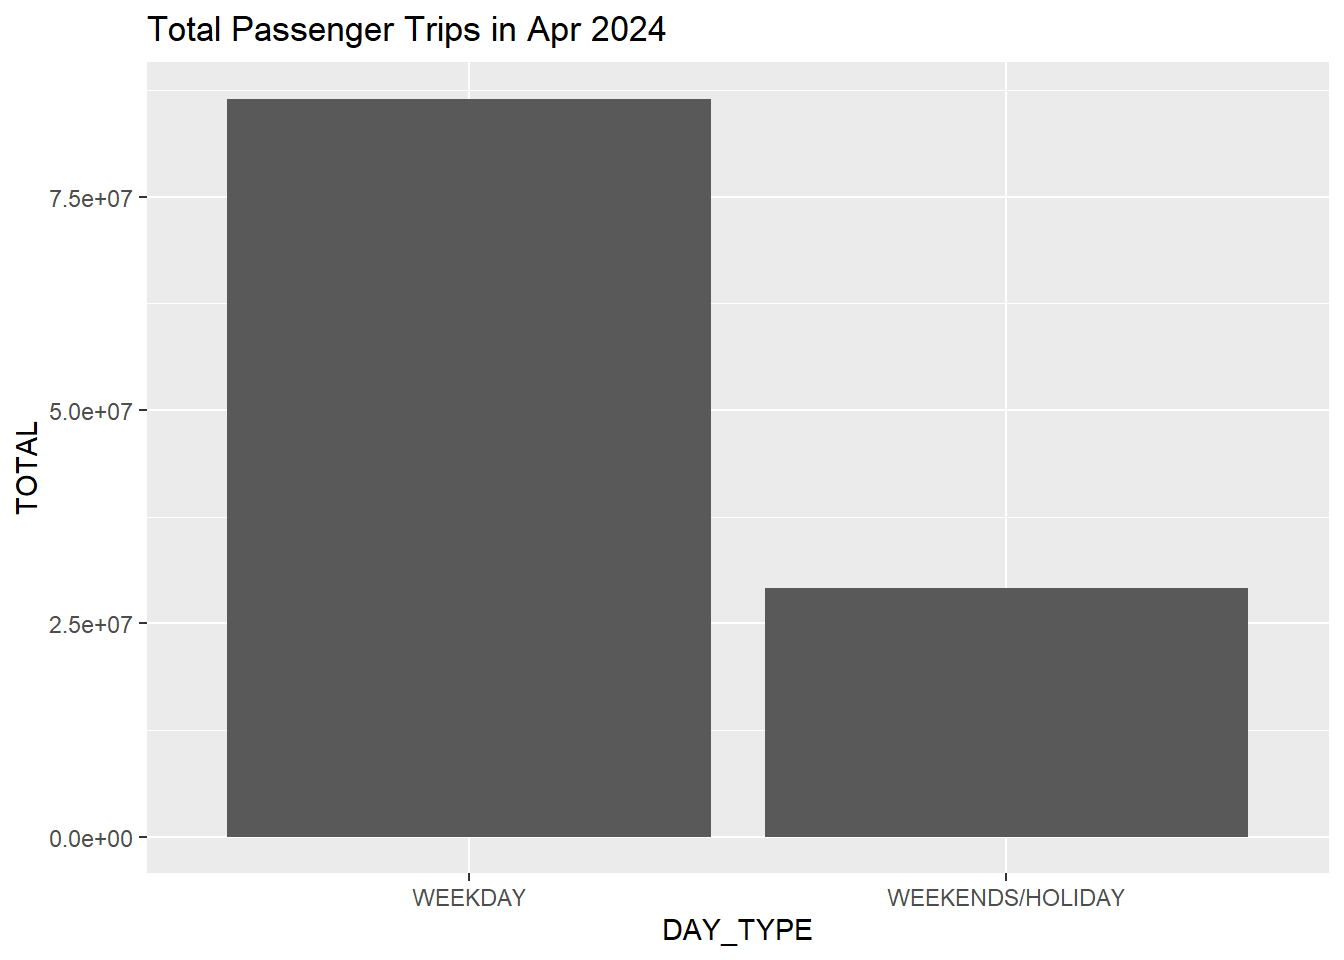

In [ ]:
total_trips <- apr_od %>% 
  group_by(DAY_TYPE) %>%
  summarise(TOTAL = sum(TOTAL_TRIPS))
  
g_total_trips <- ggplot(total_trips) + 
  geom_col(aes(x=DAY_TYPE, y=TOTAL)) + 
  ggtitle('Total Passenger Trips in Apr 2024') 

g_total_trips

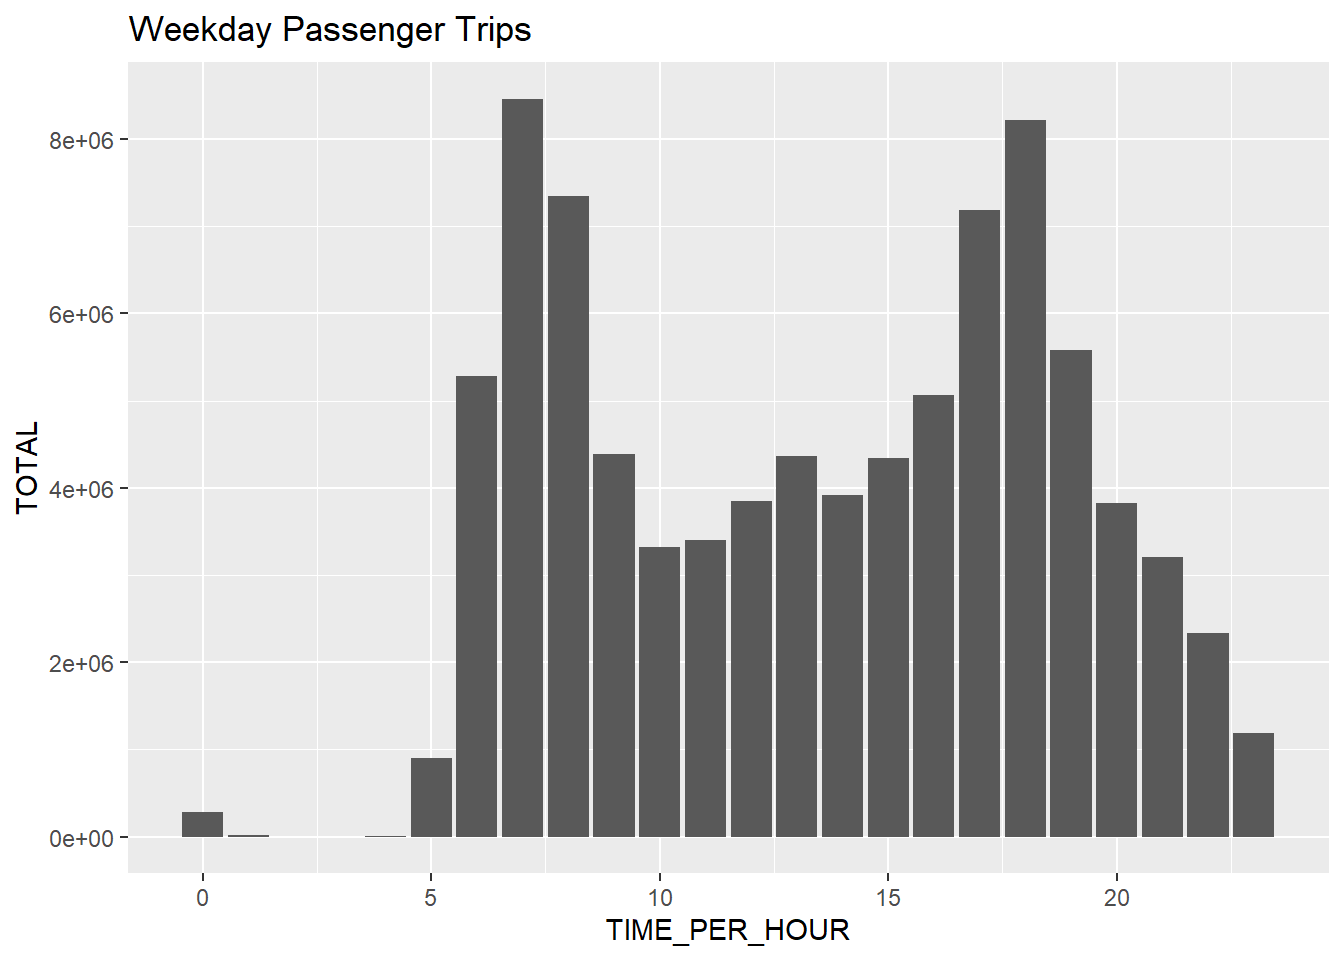

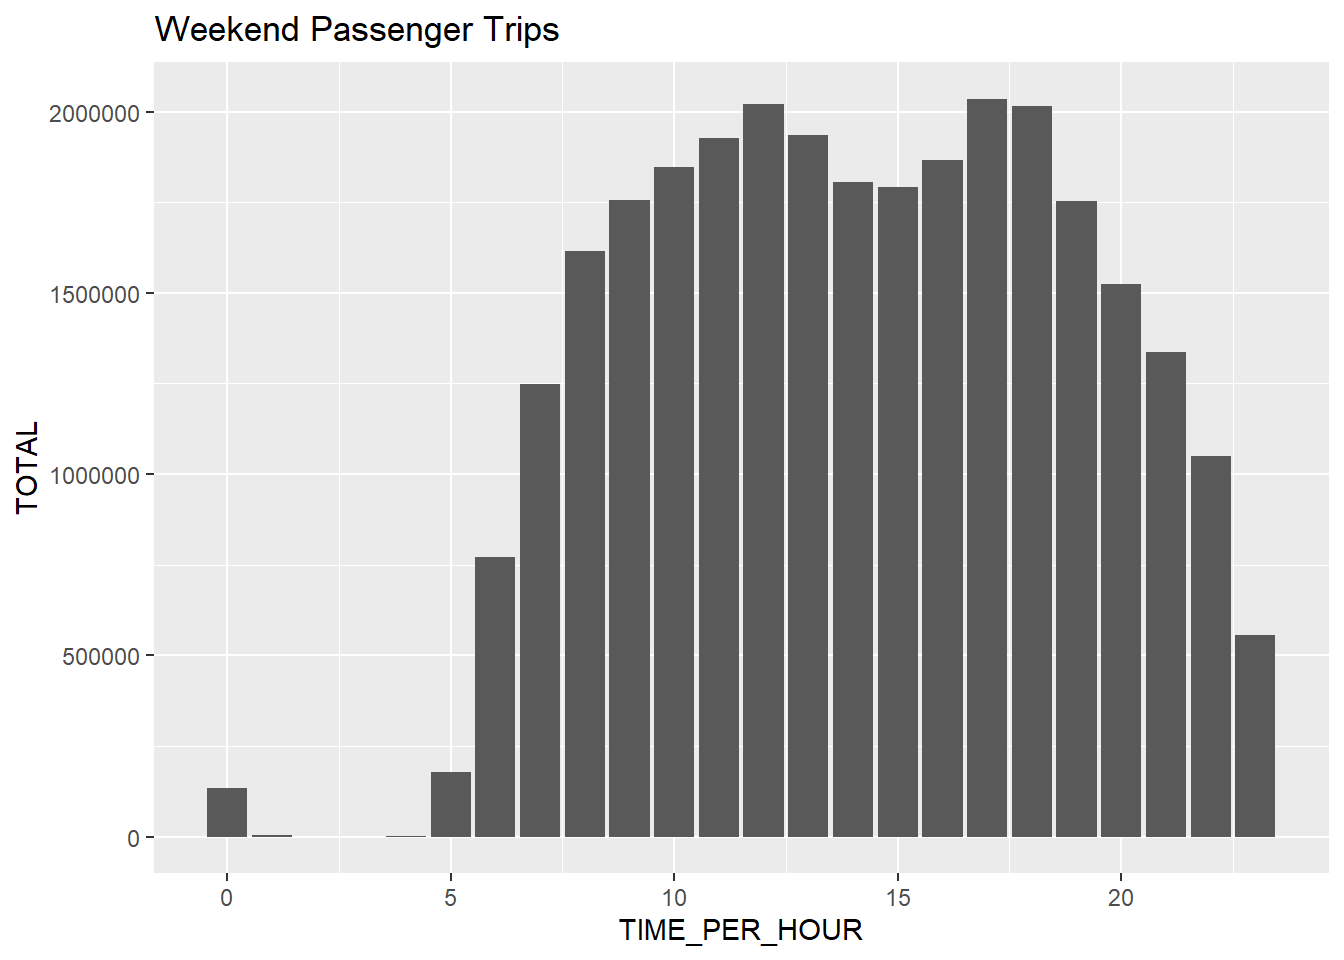

In [ ]:
weekday_trips <- apr_od %>% 
  filter(DAY_TYPE == "WEEKDAY") %>%
  group_by(TIME_PER_HOUR) %>%
  summarise(TOTAL = sum(TOTAL_TRIPS)) 
  
g_weekday_trips <- ggplot(weekday_trips) + 
  geom_col(aes(x=TIME_PER_HOUR, y=TOTAL)) + 
  ggtitle('Weekday Passenger Trips')

weekend_trips <- apr_od %>% 
  filter(DAY_TYPE == "WEEKENDS/HOLIDAY") %>%
  group_by(TIME_PER_HOUR) %>%
  summarise(TOTAL = sum(TOTAL_TRIPS))
  
g_weekend_trips <- ggplot(weekend_trips) + 
  geom_col(aes(x=TIME_PER_HOUR, y=TOTAL)) + 
  ggtitle('Weekend Passenger Trips')

g_weekday_trips  

In [ ]:
apr_trips <- apr_od %>%
  select(c(ORIGIN_PT_CODE, DAY_TYPE, TIME_PER_HOUR, TOTAL_TRIPS)) %>%
  rename(BUS_STOP_N = ORIGIN_PT_CODE) 

(head(apr_trips))

# A tibble: 6 × 4
  BUS_STOP_N DAY_TYPE         TIME_PER_HOUR TOTAL_TRIPS
  <fct>      <chr>                    <dbl>       <dbl>
1 04168      WEEKENDS/HOLIDAY            16           2
2 04168      WEEKDAY                     16           9
3 80119      WEEKENDS/HOLIDAY            14           6
4 80119      WEEKDAY                     14           8
5 44069      WEEKDAY                     17           1
6 44069      WEEKENDS/HOLIDAY            17           2

## Mapping bus stops to hexagon layer

hex layer only tell us the number of bus stops in each cell need to associate the bus stop codes with bus stop locations.

In [ ]:
bs_hex <- st_intersection(busstops, hex_layer) %>%
  st_drop_geometry() %>%
  select(c(BUS_STOP_N, hex_id))

all geometries

     BUS_STOP_N hex_id
3199      25059  H0001
2527      25751  H0002
247       26379  H0003
2340      26369  H0004
2743      25719  H0005
3547      26389  H0005

In [ ]:
bs_hex$BUS_STOP_N <- as.factor(bs_hex$BUS_STOP_N )

## Number of trips per hexagon cell

In [ ]:
trips <- inner_join(apr_trips, bs_hex)

Joining with `by = join_by(BUS_STOP_N)`

Warning in inner_join(apr_trips, bs_hex): Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 285 of `x` matches multiple rows in `y`.
ℹ Row 3125 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.

# A tibble: 6 × 5
  BUS_STOP_N DAY_TYPE         TIME_PER_HOUR TOTAL_TRIPS hex_id
  <fct>      <chr>                    <dbl>       <dbl> <fct> 
1 04168      WEEKENDS/HOLIDAY            16           2 H1257 
2 04168      WEEKDAY                     16           9 H1257 
3 80119      WEEKENDS/HOLIDAY            14           6 H1447 
4 80119      WEEKDAY                     14           8 H1447 
5 44069      WEEKDAY                     17           1 H0522 
6 44069      WEEKENDS/HOLIDAY            17           2 H0522 

In [ ]:
trips <- trips %>%
  group_by(
    hex_id,
    DAY_TYPE,
    TIME_PER_HOUR) %>%
  summarise(TOTAL_TRIPS = sum(TOTAL_TRIPS))

`summarise()` has grouped output by 'hex_id', 'DAY_TYPE'. You can override
using the `.groups` argument.

# A tibble: 6 × 4
# Groups:   hex_id, DAY_TYPE [1]
  hex_id DAY_TYPE TIME_PER_HOUR TOTAL_TRIPS
  <fct>  <chr>            <dbl>       <dbl>
1 H0001  WEEKDAY              6          15
2 H0001  WEEKDAY              7          45
3 H0001  WEEKDAY              8          14
4 H0001  WEEKDAY              9          14
5 H0001  WEEKDAY             10           6
6 H0001  WEEKDAY             11          10

# GeoVisualisation and Analysis

## Number of trips by Peak Hour

Peak Hour Periods:

-   Weekday Morning Peak - 9am to 9am

-   Weekday Afternoon Peak - 5pm to 8pm

-   Weekend/holiday Morning Peak - 11am to 2pm

-   Weekend/holiday Evening Peak - 4pm to 7pm

# Local Indicators of Spatial Association (LISA) Analysis

# Emerging Hot Spot Analysis

## time series cube